[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Buddha-subedi/Microwave_Precipitation_Retrievals_from_B-RAINS/blob/main/main_notebook_B-RAINS.ipynb)

# <center> <font color='blue'> **Boosted Transfer Learning for Passive Microwave Precipitation Retrievals** <center>

#### <center> <font color='balck'> Buddha Subedi, Mahyar Garshasbi, Ardeshir Ebtehaj <center>
#### <center> Saint Anthony Falls Laboratory, Department of Civil Environmental and Geo- Engineering,
#### <center> University of Minnesota <center>
#### <center> Date: May, 2025 (rev 01)

---
<p align="justify"> This notebook representes the results of an algorithm, called the Boosted tRansfer-leArning for PMW precIpitationN Retrievals (B-RAINS) for passive microwave retrieval of precipitation. B-RAINS enables (i) the integration of the information content from ESMs into the retrieval process and (ii) the fusion of multi-satellite observations across varying spatial and temporal resolutions through meta-model learning. The architecture leverages transfer learning by incorporating low-level priors from ESMs and refining them with high-level features derived from satellite-based active retrievals, enhancing accuracy in regions and periods with limited training data. The algorithm first detects the precipitation occurrence and phase and then estimates its rate, while conditioning the results to some key cloud microphysical and environmental variables as further explained later on in Section 1.2. Through ensemble meta-modeling, B-RAINS combines data from multiple spaceborne radars operating at Ka, Ku, and W bands to improve the detection of rainfall and snowfall. Application and validation using data from the Global Precipitation Measurement (GPM) mission and CloudSat's Cloud Profiling Radar (CPR) show that B-RAINS achieves comparable accuracy to existing methods for rain retrievals and delivers substantial improvements in global snowfall estimates when benchmarked against version V07 of the official GPM data products and Multi-Radar/Multi-Sensor System (MRMS) precipitation estimates over the contiguous United States.

This notebook is organized as follows. Section 1, describes the data including the GPM and CloudSat products as well as the ERA5 reanalysis data from the European Centre for Medium-Range Weather Forecasts (ECMWF). Section 2 describes the methodolgy for training the networks, and the last section provides an example for precipitation orbital retrieval using the proposed algorithm.

# **1. Data**

**1.1** **Data Description**

In this study, we considered coincidences of GMI and CPR from April 2014 to July 2019, and coincidences of GMI and DPR data in 2015 and 2023. Furthermore, ancillary information related to atmospheric conditions, surface types and topography are added to all coincidences using the [ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5) reanalysis products -- available at spatial resolution of 31km and [GTOPO](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-global-30-arc-second-elevation-gtopo30) -- available at spatial resolution of 1km.

**Atmospheric Variables**
*   tclw = Total Column Cloud Liquid Water ($\rm kg/m^2$)
*   tciw = Total Column Cloud Ice Water ($\rm kg/m^2$)
*   tcwv = Total Column Water Vapor ($\rm kg/m^2$)
*   cape = Convective Available Potential Energy ($\rm j/kg$)
*   t2m = 2m air temperature ($\rm K$)
*   u10 = 10m u-component of wind ($\rm m/s$)
*   v10 = 10m v-component of wind ($\rm m/s$)
*   tcslw = Total Column Supercooled Liquid Water ($\rm \frac{kg}{m^2}$)
*   tcw = Total Column Water ($\rm \frac{kg}{m^3}$)
*   cin = Convective Inhibition ($\rm j/kg$)

**Surface Type Variables**
*   lsm = LandSeaMask
*   siconc = Sea Ice Area Fraction
*   sd = Snow Depth ($\rm m$)
*   asn = Snow Albedo
*   rsn = Snow Density
*   swvl1 = Volumetric Soil Water Layer1 (-)

**Orographic Variables**
* Elevation
* Aspect

The GMI-CPR coincidences rely on the level-II CloudSat products (R05) including the 2C-PRECIP-COLUMN  and the 2C-SNOW-PROFILE that contains near-surface rain and snowfall rates.  To avoid ground-clutter contamination over complex elevated terrains, the near-surface snowfall rate is reported at 3rd (5th) radar bin above the oceans (land) at 720 (1200) m above the surface.

The 2A-DPR product, retrieved from Ku-band reflectivity, consists the near-surface precipitation phase and its intensity. It should be noted that the DPR algorithm uses precipitation phase at the lowest radar range gate uncontaminated by surface clutter, which may be 0.5--2.0 km above the surface (even over oceans).

Figure 1, represents the way the coincidences between GMI and CloudSat profiling radar (CPR) and GMI and DPR are collected. For more details with respect to the CloudSat and GMI please refer to ([2](https://journals.ametsoc.org/view/journals/hydr/22/7/JHM-D-20-0296.1.xml))

<div align="center">
  <img src="https://github.com/Buddha-subedi/Microwave_Precipitation_Retrievals_from_B-RAINS/blob/main/images/coincidence_image.png?raw=1" alt="Coincidence Image" width="800"/><br/>
  <em><strong>Figure 1.</strong> Schematic of a CloudSat-GPM coincidence segment (left), and DPR-GMI coincidence (right).</em>
</div>

Resolution mismatches between input and output data sources can introduce information redundancy and exacerbate the inherent non-uniqueness of the inverse problem in precipitation retrievals. In this study, all retrievals are performed at the nominal footprint resolution of GMI pixels (5.1$\times$13.2~km). The total number of samples, after harmonization, in phase detection (rate estimation) is 7,000,000 (1,000,000) for ERA5, 250,000 (47,123) for CPR, and 2,800,000 (1,700,000) for DPR coincidences. The data sets are partitioned into 70, 15, and 15 percent for training, testing, and validation.

## **1.2 Database Organization and Loading**

**Inputs for the phase detection and rate estimation are as follows:**
> **Inputs:**

*   $\text{TB} = X_{train}(:,1:13)$ (Brightness Temperature at 13 GMI channels [K])
*   $ \text{tciw} = X_{train}(:,14)$ (Cloud Liquid Water Path)
*   $\text{tclw} = X_{train}(:,15)$ (Cloud Ice Water Path)
*   $\text{tcwv} = X_{train}(:,16)$ (2-meter Air Temperature)
*   $\text{t2m} = X_{train}(:,17)$ (Water Vapor Path)
*   $\text{cape} = X_{train}(:,18)$ (Convective Potential Energy)

*   $\text{u10} = X_{train}(:,19)$ (10m u-component of wind)
*   $ \text{v10} = X_{train}(:,20)$ (10m v-component of wind)
*   $\text{skt} = X_{train}(:,21)$ (Skin Temperature)
*   $\text{asn} = X_{train}(:,22)$ (Snow Albedo)
*   $\text{rsn} = X_{train}(:,23)$ (Snow Density)
*   $\text{cin} = X_{train}(:,24)$ (Convective Inhibition)

*   $\text{sd} = X_{train}(:,25)$ (Snow Depth)
*   $ \text{tcslw} = X_{train}(:,26)$ (Total Column Supercooled Liquid Water)
*   $\text{tcw} = X_{train}(:,27)$ (Total Column Water)
*   $\text{swvl1} = X_{train}(:,28)$ (Snow Albedo)
*   $\text{lsm} = X_{train}(:,29)$ (Snow Density)
*   $\text{siconc} = X_{train}(:,30)$ (Convective Inhibition)

*   $\text{Latitude} = X_{train}(:,31)$ (Snow Depth)
*   $ \text{Longitude} = X_{train}(:,32)$ (Total Column Supercooled Liquid Water)
*   $\text{Month} = X_{train}(:,33)$ (Total Column Water)
*   $\text{Day} = X_{train}(:,34)$ (Snow Albedo)
*   $\text{Elevation} = X_{train}(:,35)$ (Snow Density)
*   $\text{Aspect} = X_{train}(:,36)$ (Convective Inhibition)


> **Outputs:**

*   Output of the phase network is a vector containing three integer values **0 (no precipitation)**, **1 (rainfall)**, and **2 (snowfall)**

**For the precipitation estimation, the inputs and outputs are as follows:**

> **Inputs:**

*    $\text{TB} = X_{train}(:,1:13)$ (Brightness Temperature at 13 GMI channels [K])
*   $X_k = X_{train}(:,14:36)$

> **Outputs**:

*   Output of the estimation network is a vector containing rainfall/snowfall rate [$\rm mm.hr^{-1}$].

## **1.3 Code**
To run this notebook, you need to download this folder and run the code in the Local

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import xgboost as xgb
import os
import scipy.io
import pmw_utils
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_squared_error
import scipy.stats as stats
from scipy.interpolate import interp1d
importlib.reload(pmw_utils)
from pmw_utils import plot_confusion_matrix, BRAINS_model

In [ ]:
paths = {
    'cpr': Path.cwd() / 'data' / 'df_cpr_phase.npz',
    'dpr': Path.cwd() / 'data' / 'df_dpr_phase.npz',
    'era5': Path.cwd() / 'data' / 'df_era5_phase.npz'
}

data = {k: np.load(p) for k, p in paths.items()}
df_cpr_phase, df_dpr_phase, df_era5_phase = (pd.DataFrame({k: v[k] for k in v.files}) for v in data.values())

for name, df, sep in zip(
    ['ERA5 Samples for Classification', 'CPR Samples for Classification', 'DPR Samples for CLassification'],
    [df_era5_phase, df_cpr_phase, df_dpr_phase],
    ['##############################', '##############################', '']
):
    counts = df['Prcp flag'].value_counts().sort_index()
    print(f"**{name}**\nTotal samples for classification: {len(df)}")
    print(f"Clear: {counts.get(0,0)}, Rain: {counts.get(1,0)}, Snow: {counts.get(2,0)}")
    if sep: print(sep)

**ERA5 Samples for Classification**
Total samples for classification: 7000000
Clear: 3500000, Rain: 2500000, Snow: 1000000
##############################
**CPR Samples for Classification**
Total samples for classification: 240800
Clear: 120400, Rain: 86000, Snow: 34400
##############################
**DPR Samples for CLassification**
Total samples for classification: 2800000
Clear: 1400000, Rain: 1000000, Snow: 400000


The ratio between the clear, rain and snow is 3.5:2.5:1 for the detection task

In [ ]:
paths = {
    'train': Path.cwd() / 'data' / 'era5_phase_train.npz',
    'test':  Path.cwd() / 'data' / 'era5_phase_test.npz',
    'val':   Path.cwd() / 'data' / 'era5_phase_val.npz'
}

data = {k: np.load(p) for k, p in paths.items()}
df_70_train_era5, df_15_test_era5, df_15_val_era5 = (pd.DataFrame({k: v[k] for k in v.files}) for v in data.values())

for name, df, sep in zip(
    ['ERA5 Train datasets for Classification', 'ERA5 Test datasets for Classification', 'ERA5 Validation datasets for Classification'],
    [df_70_train_era5, df_15_test_era5, df_15_val_era5],
    ['##############################', '##############################', '']
):
    counts = df['Prcp flag'].value_counts().sort_index()
    print(f"**{name}**\nTotal samples for classification: {len(df)}")
    print(f"Clear: {counts.get(0,0)}, Rain: {counts.get(1,0)}, Snow: {counts.get(2,0)}")
    if sep: print(sep)

**ERA5 Train datasets for Classification**
Total samples for classification: 4900000
Clear: 2450737, Rain: 1749424, Snow: 699839
##############################
**ERA5 Test datasets for Classification**
Total samples for classification: 1050000
Clear: 524967, Rain: 375110, Snow: 149923
##############################
**ERA5 Validation datasets for Classification**
Total samples for classification: 1050000
Clear: 524296, Rain: 375466, Snow: 150238


In [ ]:
paths = {
    'training samples':   Path.cwd() / 'data' / 'cpr_phase_train.npz',
    'testing samples':    Path.cwd() / 'data' / 'cpr_phase_test.npz',
    'validation samples': Path.cwd() / 'data' / 'cpr_phase_val.npz'
}

data = {k: np.load(p) for k, p in paths.items()}
df_70_train_cpr, df_15_test_cpr, df_15_val_cpr = (pd.DataFrame({k: v[k] for k in v.files}) for v in data.values())

for name, df, sep in zip(
    ['CPR Train sets for Classification', 'CPR Test sets for classification', 'CPR Validation sets for classification'],
    [df_70_train_cpr, df_15_test_cpr, df_15_val_cpr],
    ['##############################', '##############################', '']
):
    counts = df['Prcp flag'].value_counts().sort_index()
    print(f"**{name}**\nTotal samples for classification: {len(df)}")
    print(f"Clear: {counts.get(0,0)}, Rain: {counts.get(1,0)}, Snow: {counts.get(2,0)}")
    if sep: print(sep)

**CPR Train sets for Classification**
Total samples for classification: 168560
Clear: 84279, Rain: 60318, Snow: 23963
##############################
**CPR Test sets for classification**
Total samples for classification: 36120
Clear: 17974, Rain: 12923, Snow: 5223
##############################
**CPR Validation sets for classification**
Total samples for classification: 36120
Clear: 18147, Rain: 12759, Snow: 5214


In [ ]:
paths = {
    'training samples':   Path.cwd() / 'data' / 'dpr_phase_train.npz',
    'testing samples':    Path.cwd() / 'data' / 'dpr_phase_test.npz',
    'validation samples': Path.cwd() / 'data' / 'dpr_phase_val.npz'
}
data = {k: np.load(p) for k, p in paths.items()}
df_70_train_dpr, df_15_test_dpr, df_15_val_dpr = (pd.DataFrame({k: v[k] for k in v.files}) for v in data.values())

for name, df, sep in zip(
    ['DPR Train sets for classification', 'DPR Test sets for classification', 'DPR Validation sets for classification'],
    [df_70_train_dpr, df_15_test_dpr, df_15_val_dpr],
    ['##############################', '##############################', '']
):
    counts = df['Prcp flag'].value_counts().sort_index()
    print(f"**{name}**\nTotal samples for classification: {len(df)}")
    print(f"Clear: {counts.get(0,0)}, Rain: {counts.get(1,0)}, Snow: {counts.get(2,0)}")
    if sep: print(sep)

**DPR Train sets for classification**
Total samples for classification: 1960000
Clear: 980093, Rain: 700244, Snow: 279663
##############################
**DPR Test sets for classification**
Total samples for classification: 420000
Clear: 210110, Rain: 149723, Snow: 60167
##############################
**DPR Validation sets for classification**
Total samples for classification: 420000
Clear: 209797, Rain: 150033, Snow: 60170


# **2.  METHODOLOGY**
Boosted tRansfer-leArning for precIpitatioN RetrievalS (B-RAINS) presents an ensemble learning architecture that stacks parallel XGBoost base learners and combines their inference through a meta-model. initially, a finite set of top boosters is trained exclusively on ERA5 data, after which these boosters are frozen -- that is, their structure, including the number of trees, depth, nodes, and splitting criteria, is fixed. Additional bottom boosters are then appended and trained on satellite-based observations to capture the finer-scale information embedded in active retrievals. Each base learner is satellite-specific and tailored to either DPR or CPR data. In the classification stage, the base learners' output class probabilities represent clear, snowy, and rainy from both ERA5-CPR and ERA5-DPR, which are then fused using an XGBoost meta-model, producing the final precipitation phase prediction. Following phase classification, two additional parallel base learners estimate rain and snow rates, respectively.

<div align="center">
  <img src="https://github.com/Buddha-subedi/Microwave_Precipitation_Retrievals_from_B-RAINS/blob/main/images/Fig_01.png?raw=1" alt="B-RAINS Architecture" width="700"/><br/>
  <em>
    <strong>Figure 2.</strong> The architecture of the Boosted tRansfer-leArning for precIpitatioN RetrievalS (B-RAINS) that stacks parallel XGBoost base learners and combines their inference through a meta-model. Step 1 detects the precipitation occurrence and phase, and Step 2 estimates the rain and snow rate, with the subscripts <code>L</code> and <code>R</code> denoting labels and rates of the data sets. The retrievals transfer the learning from ERA5 to satellite through incremental training of the base learners in both steps. After learning ERA5, the number of parallel trees, tree booster numbers, depths, and splitting nodes are frozen (FZ) for the top part of the decision trees.
  </em>
</div>

Figure 3 displays precipitation retrievals for a snowstorm and a rainstorm observed by GMI orbit 027551 over the Southern and Indian Oceans. The first column shows results using only $n_e = 90$ boosting rounds, trained exclusively on ERA5 precipitation flags and rates. When additional $n_s$ boosting trees are incrementally added to capture the information content of satellite data pairs, finer spatial details and higher intensity values emerge. Concurrently, low-intensity precipitation at the storm peripheries, initially shaped by learning from the coarse resolution of ERA5, gradually diminishes, as B-RAINS adapts and partially ``forgets'' the low-resolution ERA5 data in favor of a higher fidelity to satellite information.

<div align="center">
  <img src="https://github.com/Buddha-subedi/Microwave_Precipitation_Retrievals_from_B-RAINS/blob/main/images/Fig_03.png?raw=1" alt="Impact of Transfer Learning" width="800"/><br/>
  <em>
    <strong>Figure 3.</strong> Impacts of transfer learning on retrievals of a rain storm (a–e) and a snow storm (f–j) over the Southern and Indian Oceans on 01/04/2019 (orbit 027551), with <code>n_e</code> and <code>n_s</code> denoting the boosting rounds used to learn ERA5 (before freezing) and satellite precipitation (after freezing), where the ERA5 simulations and DPR retrievals are shown for visual comparisons.
  </em>
</div>

<div align="center">
  <img src="https://github.com/Buddha-subedi/Microwave_Precipitation_Retrievals_from_B-RAINS/blob/main/images/Fig_04.png?raw=1" alt="Confusion Metrics" width="800"/><br/>
  <em>
    <strong>Figure 4.</strong> The confusion metrics of the B-RAINS detection step, stratified for the test dataset over different surface types.
  </em>
</div>

<div align="center">
  <img src="https://raw.githubusercontent.com/Buddha-subedi/Microwave_Precipitation_Retrievals_from_B-RAINS/main/images/Fig_05.png" alt="Scatter Plot" width="850"/><br/>
  <em>
    <strong>Figure 5.</strong> Density scatter plots for the rainfall (a) and snowfall (b) retrievals against the DPR and CPR test sets, with RMSE values (c) stratified by surface types after cumulative density matching. RMSE values are also shown for equal-sized combined test sets: DPR+ERA5 and CPR+ERA5 in the panel c.
  </em>
</div>


## **2.1  Training B-RAINS**

**Note:** The pre-trained networks are saves in the "Model" directory and will be used throughout the notebook. However, a sample of the training process is demonstrated for training the base learners for classification using ERA5 and CPR data and regression for the snow rate using ERA5 and CPR data

[0]	train-merror:0.11015	test-merror:0.13395	val-merror:0.13342
[1]	train-merror:0.10129	test-merror:0.12749	val-merror:0.12726
[2]	train-merror:0.09576	test-merror:0.12415	val-merror:0.12364
[3]	train-merror:0.09127	test-merror:0.12144	val-merror:0.12102
[4]	train-merror:0.08756	test-merror:0.11920	val-merror:0.11894
[5]	train-merror:0.08440	test-merror:0.11744	val-merror:0.11709
[6]	train-merror:0.08138	test-merror:0.11575	val-merror:0.11548
[7]	train-merror:0.07863	test-merror:0.11436	val-merror:0.11389
[8]	train-merror:0.07627	test-merror:0.11305	val-merror:0.11268
[9]	train-merror:0.07418	test-merror:0.11209	val-merror:0.11153
[10]	train-merror:0.07203	test-merror:0.11097	val-merror:0.11032
[11]	train-merror:0.07038	test-merror:0.11001	val-merror:0.10933
[12]	train-merror:0.06894	test-merror:0.10913	val-merror:0.10852
[13]	train-merror:0.06792	test-merror:0.10860	val-merror:0.10793
[14]	train-merror:0.06694	test-merror:0.10804	val-merror:0.10745
[15]	train-merror:0.06609	test-merr

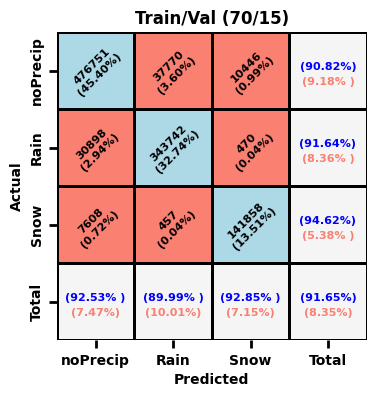

In [ ]:
input_vars = ['10v', '10h', '18v', '18h','23v','36v', '36h', '89v', '89h', '166v', '166h','183-3', '183-7',
                        'tciw','tclw','tcwv','t2m','cape','u10', 'v10', 'skt','asn', 'rsn', 'cin',
              'sd', 'tcslw','tcw','swvl1','lsm', 'siconc', 'Latitude','Longitude', 'Month', 'Day', 'mean_aspect', 'elevation_mean']
x_train_70_era5 = df_70_train_era5[input_vars]
y_train_70_era5 = df_70_train_era5['Prcp flag']

x_test_15_era5 = df_15_test_era5[input_vars]
y_test_15_era5 = df_15_test_era5['Prcp flag']

x_val_15_era5 = df_15_val_era5[input_vars]
y_val_15_era5 = df_15_val_era5['Prcp flag']

dtrain = xgb.DMatrix(x_train_70_era5, label=y_train_70_era5)
dtest = xgb.DMatrix(x_test_15_era5, label=y_test_15_era5)
dval = xgb.DMatrix(x_val_15_era5, label=y_val_15_era5)

evals = [(dtrain, 'train'), (dtest, 'test'), (dval, 'val')]


params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'merror',
    'reg_alpha': 0.095,
    'reg_lambda': 7.843,
    'max_depth': 18,
    'num_parallel_tree': 3,
    'learning_rate': 0.330808,
    'gamma': 0.661776,
    'verbosity': 0
}

booster_era5 = xgb.train(
    params=params,
    dtrain=dtrain,
    evals=evals,
    num_boost_round=93,
    verbose_eval=True
)

y_pred = booster_era5.predict(dtest)

plot_confusion_matrix(y_test_15_era5, y_pred, 'Predicted', 'Actual', 'Train/Val (70/15)')

In second round of training, architecture of trees trained on the ERA5 will be frozen -- that is, their structure, including the number of trees, depth, nodes, and splitting criteria, is fixed. Additional bottom boosters are then appended and trained on satellite-based observations to capture the finer-scale information embedded in active retrievals.

In [ ]:
x_train_70_cpr = df_70_train_cpr[input_vars]
y_train_70_cpr = df_70_train_cpr['Prcp flag']

x_test_15_cpr = df_15_test_cpr[input_vars]
y_test_15_cpr = df_15_test_cpr['Prcp flag']

x_val_15_cpr = df_15_val_cpr[input_vars]
y_val_15_cpr = df_15_val_cpr['Prcp flag']

x_era5 = df_15_test_era5[input_vars]
y_era5 = df_15_test_era5['Prcp flag']

classes = np.unique(df_70_train_cpr['Prcp flag'])
class_weights = {0: 1, 1: 1.167, 2: 1.766}


sample_weights_70 = df_70_train_cpr['Prcp flag'].map(lambda x: class_weights[classes.tolist().index(x)])


dtrain_cpr = xgb.DMatrix(x_train_70_cpr, label=y_train_70_cpr, weight=sample_weights_70)
dtest_cpr = xgb.DMatrix(x_test_15_cpr, label=y_test_15_cpr)
dval_cpr = xgb.DMatrix(x_val_15_cpr, label=y_val_15_cpr)
dera5 = xgb.DMatrix(x_era5, label=y_era5)

evals = [(dtrain_cpr, 'train_cpr'), (dtest_cpr, 'test_cpr'), (dval_cpr, 'val_cpr'), (dera5, 'era5')]

f1_train_cpr_rain_values, f1_test_cpr_rain_values, f1_val_cpr_rain_values, f1_era5_rain_values = [], [], [], []
f1_train_cpr_snow_values, f1_test_cpr_snow_values, f1_val_cpr_snow_values, f1_era5_snow_values = [], [], [], []

def f1_eval_all_classes(preds, dtrain):
    labels = dtrain.get_label()
    preds = preds.argmax(axis=1)
    f1_scores = f1_score(labels, preds, labels=[1, 2], average=None)
    f1_rain, f1_snow = f1_scores[0], f1_scores[1]

    if dtrain == dtrain_cpr:
        f1_train_cpr_rain_values.append(f1_rain)
        f1_train_cpr_snow_values.append(f1_snow)
    elif dtrain == dtest_cpr:
        f1_test_cpr_rain_values.append(f1_rain)
        f1_test_cpr_snow_values.append(f1_snow)
    elif dtrain == dera5:
        f1_era5_rain_values.append(f1_rain)
        f1_era5_snow_values.append(f1_snow)
    elif dtrain == dval_cpr:
        f1_val_cpr_rain_values.append(f1_rain)
        f1_val_cpr_snow_values.append(f1_snow)

    return 'f1_snow', f1_snow

# Set parameters
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'merror',
    'subsample': 0.5,
    'reg_alpha': 6.948,
    'reg_lambda': 5.0278,
    'max_depth': 18,
    'num_parallel_tree': 6,
    'learning_rate': 0.018,
    'gamma': 0.32,
    'verbosity': 0
}

# Train with the new data
booster = xgb.train(
    params,
    dtrain_cpr,
    num_boost_round=182,
    evals=evals,
    xgb_model=booster_era5,
    verbose_eval=True,
    feval=f1_eval_all_classes
)

# Final model evaluation
y_pred_cpr_finetune = booster.predict(dtest_cpr)
accuracy = accuracy_score(y_test_15_cpr, y_pred_cpr_finetune)
print(f"Test accuracy: {accuracy:.2f}")

C:\Users\subed042\AppData\Local\anaconda3\envs\Created\Lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train_cpr-merror:0.21503	train_cpr-f1_snow:0.82169	test_cpr-merror:0.23735	test_cpr-f1_snow:0.82082	val_cpr-merror:0.24225	val_cpr-f1_snow:0.81910	era5-merror:0.08330	era5-f1_snow:0.93737
[1]	train_cpr-merror:0.21372	train_cpr-f1_snow:0.82228	test_cpr-merror:0.23583	test_cpr-f1_snow:0.82151	val_cpr-merror:0.24067	val_cpr-f1_snow:0.81991	era5-merror:0.08320	era5-f1_snow:0.93741
[2]	train_cpr-merror:0.21235	train_cpr-f1_snow:0.82308	test_cpr-merror:0.23425	test_cpr-f1_snow:0.82268	val_cpr-merror:0.23923	val_cpr-f1_snow:0.82030	era5-merror:0.08323	era5-f1_snow:0.93753
[3]	train_cpr-merror:0.21093	train_cpr-f1_snow:0.82363	test_cpr-merror:0.23278	test_cpr-f1_snow:0.82322	val_cpr-merror:0.23774	val_cpr-f1_snow:0.82055	era5-merror:0.08340	era5-f1_snow:0.93757
[4]	train_cpr-merror:0.20970	train_cpr-f1_snow:0.82411	test_cpr-merror:0.23120	test_cpr-f1_snow:0.82375	val_cpr-merror:0.23583	val_cpr-f1_snow:0.82139	era5-merror:0.08364	era5-f1_snow:0.93764
[5]	train_cpr-merror:0.20822	train_cpr-f

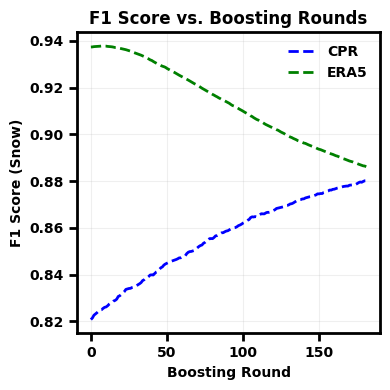

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
plt.plot(f1_test_cpr_snow_values, label='CPR', color='blue', linewidth=2, linestyle='--')
plt.plot(f1_era5_snow_values, label='ERA5', color='green', linewidth=2, linestyle='--')

# Axis labels and title
plt.xlabel('Boosting Round', fontsize=10, fontweight='bold')
plt.ylabel('F1 Score (Snow)', fontsize=10, fontweight='bold')
plt.title('F1 Score vs. Boosting Rounds', fontsize=12, fontweight='bold')

# Legend
plt.legend(fontsize=10, frameon=False, loc='best', prop={'weight': 'bold'})

# Tick labels
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

# Tick size
plt.tick_params(axis='both', which='major', length=6, width=2)

# Make axis spines bold
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.grid(True, alpha=0.2)
plt.tight_layout()

plt.show()

Example for training the base learners for snow regression is also shown as an example below

In [ ]:
paths = {
    'ERA5 Snow Rate': Path.cwd() / 'data' / 'df_era5_snow_rate.npz',
    'CPR Snow Rate':  Path.cwd() / 'data' / 'df_csat_snow_rate.npz'
}

# Load data
data = {k: np.load(p) for k, p in paths.items()}
df_era5_snow_rate, df_cpr_snow_rate = (pd.DataFrame({k: v[k] for k in v.files}) for v in data.values())

# Print total number of samples using shape
for name, df, sep in zip(
    ['ERA5 Samples for Snow Retrievals', 'CPR Samples for Snow Regression'],
    [df_era5_snow_rate, df_cpr_snow_rate],
    ['##############################', '']
):
    print(f"**{name}**")
    print(f"Total samples for classification: {df.shape[0]}")
    if sep: print(sep)

**ERA5 Samples for Snow Retrievals**
Total samples for classification: 1000000
##############################
**CPR Samples for Snow Regression**
Total samples for classification: 47123


In [ ]:
snowr_input = ['10v', '10h', '18v', '18h','23v','36v', '36h', '89v', '89h', '166v', '166h','183-3', '183-7',
                        'tciw','tclw','tcwv','t2m','cape','u10', 'v10','cin', 'skt','asn', 'rsn',
              'sd', 'tcslw','tcw','swvl1','lsm', 'siconc', 'Latitude','Longitude', 'Month', 'Day', 'mean_aspect',
             'elevation_mean']

df_70_snow_train_era5, df_30_snow_era5 = train_test_split(df_era5_snow_rate, test_size=0.3, random_state=42)
df_15_snow_test_era5, df_15_snow_val_era5 = train_test_split(df_30_snow_era5, test_size=0.5, random_state=42)
X_train_snow_era5 = df_70_snow_train_era5[snowr_input]
y_train_snow_era5 = df_70_snow_train_era5['snow_rate']

X_test_snow_era5 = df_15_snow_test_era5[snowr_input]
y_test_snow_era5 = df_15_snow_test_era5['snow_rate']

X_val_snow_era5 = df_15_snow_val_era5[snowr_input]
y_val_snow_era5 = df_15_snow_val_era5['snow_rate']

# Convert to DMatrix format
dtrain_snow_era5 = xgb.DMatrix(X_train_snow_era5, label=y_train_snow_era5)
dtest_snow_era5 = xgb.DMatrix(X_test_snow_era5, label=y_test_snow_era5)
dval_snow_era5 = xgb.DMatrix(X_val_snow_era5, label=y_val_snow_era5)

# Define evaluation metrics and watchlist
evals = [(dtrain_snow_era5, 'train'), (dtest_snow_era5, 'test'), (dval_snow_era5, 'val')]

evals_result = {}

# Define parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'seed': 42,
    'learning_rate': 0.0392,
    'max_depth': 14,
    'reg_alpha': 4.52,
    'reg_lambda': 7.139,
    'n_estimators': 92,
    'num_parallel_tree': 6,
    'eval_metric': ['rmse']
}

# Train the model with early stopping
xgb_reg_snow_era5 = xgb.train(params, dtrain_snow_era5, num_boost_round=92, evals=evals, evals_result=evals_result, early_stopping_rounds=50)

[0]	train-rmse:0.20224	test-rmse:0.20305	val-rmse:0.20154
[1]	train-rmse:0.19673	test-rmse:0.19758	val-rmse:0.19606
[2]	train-rmse:0.19148	test-rmse:0.19238	val-rmse:0.19089
[3]	train-rmse:0.18648	test-rmse:0.18743	val-rmse:0.18597
[4]	train-rmse:0.18172	test-rmse:0.18273	val-rmse:0.18129
[5]	train-rmse:0.17718	test-rmse:0.17825	val-rmse:0.17682
[6]	train-rmse:0.17287	test-rmse:0.17402	val-rmse:0.17259
[7]	train-rmse:0.16876	test-rmse:0.16996	val-rmse:0.16857
[8]	train-rmse:0.16485	test-rmse:0.16615	val-rmse:0.16474
[9]	train-rmse:0.16114	test-rmse:0.16253	val-rmse:0.16109
[10]	train-rmse:0.15759	test-rmse:0.15909	val-rmse:0.15765
[11]	train-rmse:0.15424	test-rmse:0.15584	val-rmse:0.15441
[12]	train-rmse:0.15106	test-rmse:0.15275	val-rmse:0.15132
[13]	train-rmse:0.14803	test-rmse:0.14982	val-rmse:0.14839
[14]	train-rmse:0.14514	test-rmse:0.14702	val-rmse:0.14563
[15]	train-rmse:0.14240	test-rmse:0.14438	val-rmse:0.14301
[16]	train-rmse:0.13981	test-rmse:0.14188	val-rmse:0.14054
[17]	tr

In [ ]:
df_70_snow_train_sat, df_30_snow_sat = train_test_split(df_cpr_snow_rate, test_size=0.3, random_state=42)
df_15_snow_test_sat, df_15_snow_val_sat = train_test_split(df_30_snow_sat, test_size=0.5, random_state=42)

X_train_snow_sat = df_70_snow_train_sat[snowr_input]
y_train_snow_sat = df_70_snow_train_sat['snow_rate']
X_test_snow_sat = df_15_snow_test_sat[snowr_input]
y_test_snow_sat = df_15_snow_test_sat['snow_rate']

dtrain_snow_rate_sat = xgb.DMatrix(X_train_snow_sat, label=y_train_snow_sat)
dtest_snow_rate_sat = xgb.DMatrix(X_test_snow_sat, label=y_test_snow_sat)

evals = [(dtest_snow_era5, 'test_era5'), (dtest_snow_rate_sat, 'test_sat'), (dtrain_snow_rate_sat, 'train_sat')]
evals_result = {}

# Set parameters for fine-tuning
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.01,
    'eval_metric': 'rmse',
    'max_depth': 15
}

# Continue training with the new data
snow_rate_booster = xgb.train(
    params,
    dtrain_snow_rate_sat,
    num_boost_round=183,
    evals=evals,
    xgb_model=xgb_reg_snow_era5,
    evals_result=evals_result,
    verbose_eval=True
)


y_pred_snow_rate_sat = snow_rate_booster.predict(dtest_snow_rate_sat)

mse_new = mean_squared_error(y_test_snow_sat, y_pred_snow_rate_sat)
print(f"Test Mean Squared Error: {mse_new:.2f}")

[0]	test_era5-rmse:0.09539	test_sat-rmse:0.30482	train_sat-rmse:0.30901
[1]	test_era5-rmse:0.09541	test_sat-rmse:0.30394	train_sat-rmse:0.30781
[2]	test_era5-rmse:0.09545	test_sat-rmse:0.30309	train_sat-rmse:0.30663
[3]	test_era5-rmse:0.09550	test_sat-rmse:0.30225	train_sat-rmse:0.30545
[4]	test_era5-rmse:0.09557	test_sat-rmse:0.30144	train_sat-rmse:0.30429
[5]	test_era5-rmse:0.09564	test_sat-rmse:0.30061	train_sat-rmse:0.30314
[6]	test_era5-rmse:0.09568	test_sat-rmse:0.29984	train_sat-rmse:0.30213
[7]	test_era5-rmse:0.09577	test_sat-rmse:0.29905	train_sat-rmse:0.30100
[8]	test_era5-rmse:0.09588	test_sat-rmse:0.29826	train_sat-rmse:0.29987
[9]	test_era5-rmse:0.09599	test_sat-rmse:0.29750	train_sat-rmse:0.29877
[10]	test_era5-rmse:0.09604	test_sat-rmse:0.29676	train_sat-rmse:0.29779
[11]	test_era5-rmse:0.09618	test_sat-rmse:0.29602	train_sat-rmse:0.29671
[12]	test_era5-rmse:0.09632	test_sat-rmse:0.29528	train_sat-rmse:0.29563
[13]	test_era5-rmse:0.09639	test_sat-rmse:0.29456	train_sat-r

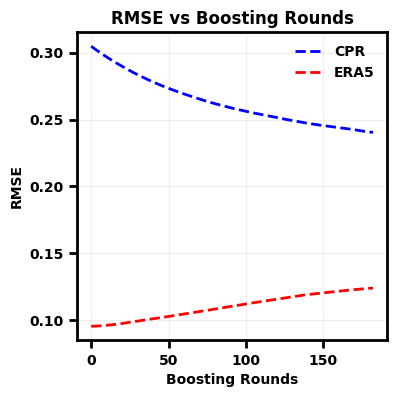

In [ ]:
# Extract RMSE values
train_rmse = evals_result['test_sat']['rmse']
test_rmse = evals_result['test_era5']['rmse']

# Plot RMSE vs Boosting rounds
plt.figure(figsize=(4, 4))
plt.plot(train_rmse, label='CPR', color='blue', linestyle='--', linewidth=2)
plt.plot(test_rmse, label='ERA5', color='red', linestyle='--', linewidth=2)
#plt.plot(val_rmse, label='Validation RMSE', color='green')
plt.xlabel('Boosting Rounds', fontsize=10, fontweight='bold')
plt.ylabel('RMSE', fontsize=10, fontweight='bold')

plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tick_params(axis='both', which='major', length=6, width=2)
plt.title('RMSE vs Boosting Rounds', fontsize=12, fontweight='bold')
plt.legend(fontsize=10, frameon=False, loc='best', prop={'weight':'bold'})
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)
plt.grid(True, alpha=0.2)
plt.show()

# **3.  Orbial Retrievals**

In this section, the pre-trained models are loaded to retrieve rainfall and snowfall for two GMI orbits.

## **3.1) Running B-RAINS for the selected orbit**

### **3.1.1 Loading the trained models and the input dataset**

There are two main steps for orbital retrieval using DIEGO algorithm.

**Step 1: Loading the trained networks**
The pre-trained networks can be loaded along using the Load_Model module. All the pre-trained networks are saves in the "Model" directory.



**Step 2: Loading the inputs for the selected orbit**
For retrieving precipitation over each GMI orbits input file should be prepared containing the features that are described Section 1.2. For the two sample orbits that are shown in this notook this files are prepared and are available to download

In [ ]:
model_dir = Path.cwd() / 'model'

era5_dpr_base_learner = xgb.XGBClassifier()
era5_dpr_base_learner.load_model(os.path.join(model_dir, 'classifier_incremental_dpr.json'))

era5_cpr_base_learner = xgb.XGBClassifier()
era5_cpr_base_learner.load_model(os.path.join(model_dir, 'classifier_incremental_cpr.json'))

meta_model = xgb.XGBClassifier()
meta_model.load_model(os.path.join(model_dir, 'incremental_meta.json'))

snow_rate_booster_tl = xgb.Booster()
snow_rate_booster_tl.load_model(os.path.join(model_dir, 'xgb_tl_snow_rate.json'))

rain_rate_booster_tl = xgb.Booster()
rain_rate_booster_tl.load_model(os.path.join(model_dir, 'xgb_tl_rain_rate.json'))

In [ ]:
data_dir = Path.cwd() / 'data'
#r'G:\Shared drives\SAFL Ebtehaj Group\Buddha Research\Research 1\data'


path_cdf_match_rain = os.path.join(data_dir, "cdf_match_for_rain.npz")
data_cdf_match_rain = np.load(path_cdf_match_rain)
df_cdf_match_rain = pd.DataFrame({key: data_cdf_match_rain[key] for key in data_cdf_match_rain.files})


path_cdf_match_snow = os.path.join(data_dir, "cdf_match_for_snow.npz")
data_cdf_match_snow = np.load(path_cdf_match_snow)
df_cdf_match_snow = pd.DataFrame({key: data_cdf_match_snow[key] for key in data_cdf_match_snow.files})

### **3.1.2. Estimating precipitation for the selected orbit**
To retrieve precipitation for the selected orbit the BRAINS_model function should be used.

In [ ]:
import scipy.io
file_path = 'G:\Shared drives\SAFL Ebtehaj Group\Buddha Research\data_production\sample_mat_files\Pred_DEM_X_ERA5_20150112_004968.mat';
[phase, rain, snow, latitude, longitude] = BRAINS_model(file_path, era5_dpr_base_learner, era5_cpr_base_learner, meta_model,
                     snow_rate_booster_tl, rain_rate_booster_tl,
                     df_cdf_match_rain, df_cdf_match_snow);

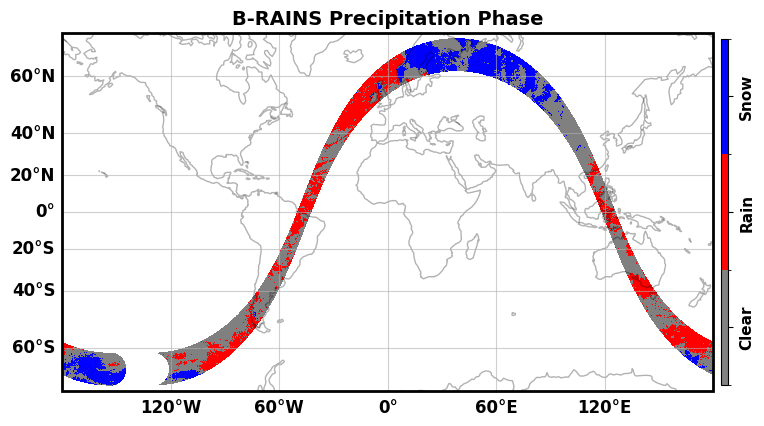

In [ ]:

cmap_custom = mcolors.ListedColormap(['grey', 'red', 'blue'])
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap_custom.N)

# Create figure for ERA5_flag
fig1 = plt.figure(figsize=(10, 6))
ax1 = fig1.add_subplot(111, projection=ccrs.Mercator())

mask = (longitude > 179.5) | (longitude < -179.5)
ERA5_flag_2d_masked = np.ma.masked_where(mask, phase)

# Plot using pcolormesh
plot1 = ax1.pcolormesh(longitude, latitude, ERA5_flag_2d_masked, cmap=cmap_custom, norm=norm, alpha=0.98, transform=ccrs.PlateCarree())
ax1.coastlines(alpha=0.3)

g4 = ax1.gridlines(draw_labels=True, alpha=0.6)
g4.top_labels = False
g4.right_labels = False
g4.xlabels_bottom = True
g4.ylabels_left = True
g4.xlabel_style = {'fontsize': 12, 'fontweight': 'bold'}
g4.ylabel_style = {'fontsize': 12, 'fontweight': 'bold'}


cbar1 = plt.colorbar(plot1, ax=ax1, orientation='vertical', shrink=0.75, pad=0.01, aspect=50)
cbar1.set_ticks([0.5, 1.5, 2.5])
cbar1.set_ticklabels(['Clear', 'Rain', 'Snow'])
for t in cbar1.ax.get_yticklabels():
    t.set_fontweight('bold')
    t.set_fontsize(11)
    t.set_rotation(90)
    t.set_ha('center')
    t.set_va('center')
cbar1.ax.tick_params(pad=10)
ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
for spine in ax1.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
ax1.set_title('B-RAINS Precipitation Phase', fontsize=14, fontweight='bold')


plt.show()

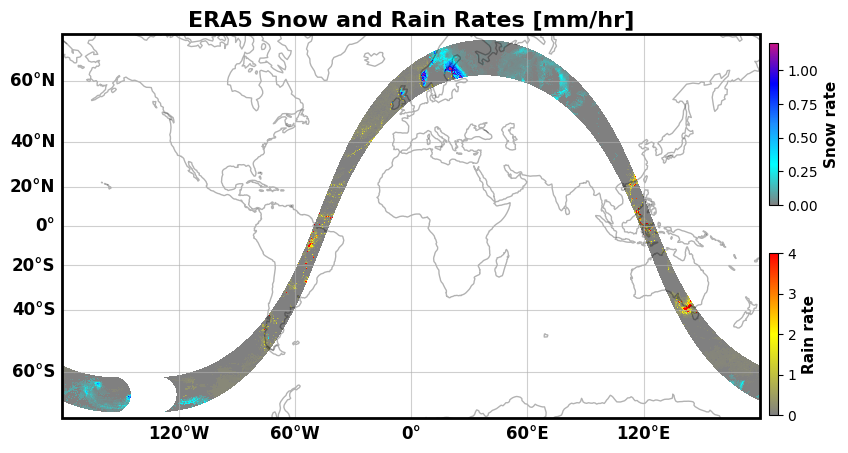

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs

# Define color maps
colors_snow = ['grey', 'cyan', 'dodgerblue', 'blue', 'mediumvioletred']
cmap_rate_snow = LinearSegmentedColormap.from_list("mycmap_snow", colors_snow)

colors_rain = ['grey', 'yellow', 'red']
cmap_rate_rain = LinearSegmentedColormap.from_list("mycmap_rain", colors_rain)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.Mercator()})


snow_era5_masked = np.ma.masked_where(mask, snow)
rain_era5_masked = np.ma.masked_where(mask, rain)

snow_rate_era5_masked = np.ma.masked_where(rain_era5_masked > snow_era5_masked, snow)
rain_rate_era5_masked = np.ma.masked_where(snow_era5_masked > rain_era5_masked, rain)

# Plot snow and rain
plot1 = ax1.pcolormesh(longitude, latitude, snow_rate_era5_masked, vmin=0, vmax=1.2,
                       cmap=cmap_rate_snow, transform=ccrs.PlateCarree())
plot2 = ax1.pcolormesh(longitude, latitude, rain_rate_era5_masked, vmin=0, vmax=4,
                       cmap=cmap_rate_rain, transform=ccrs.PlateCarree())

# Coastlines and grid
ax1.coastlines(alpha=0.3)
g4 = ax1.gridlines(draw_labels=True, alpha=0.6)
g4.top_labels = False
g4.right_labels = False
g4.xlabels_bottom = True
g4.ylabels_left = True
g4.xlabel_style = {'fontsize': 12, 'fontweight': 'bold'}
g4.ylabel_style = {'fontsize': 12, 'fontweight': 'bold'}
ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
for spine in ax1.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
ax1.set_title('ERA5 Snow and Rain Rates [mm/hr]', fontsize=16, fontweight='bold')


cbar_ax1 = fig.add_axes([0.91, 0.53, 0.01, 0.27])
cbar_ax2 = fig.add_axes([0.91, 0.18, 0.01, 0.27])

cbar1 = fig.colorbar(plot1, cax=cbar_ax1)
cbar1.set_label('Snow rate', fontsize=11, fontweight='bold')

cbar2 = fig.colorbar(plot2, cax=cbar_ax2)
cbar2.set_label('Rain rate', fontsize=11, fontweight='bold')

plt.show()

Comparison of orbital retrievals with different available precipitation products.

<div align="center">
  <img src="https://github.com/Buddha-subedi/Microwave_Precipitation_Retrievals_from_B-RAINS/blob/main/images/Fig_08.png?raw=1" alt="Orbital Retrievals" width="800"/><br/>
  <em>
    <strong>Figure 6.</strong> Brightness temperatures from GMI (a--d) and precipitation retrievals from B-RAINS (e), GPROF (f), DPR (g), and ERA5 (h) for orbit 044780 on January 15, 2022, capturing an extratropical cyclone over the North Atlantic Ocean and the Canadian provinces of Nova Scotia and New Brunswick.
  </em>
</div>

### **3.1.3. Automated Code for Visualising all the variables**
You can viuslaise any variables of your interest

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install netCDF4
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 99.1 MB/s eta 0:00:00


Enter orbit number: 004912
Found file: /content/drive/Shared drives/SAFL Ebtehaj Group/Buddha Research/data_production/sample_netcdf_files/B-RAINS_20150109_004912.nc

Available top-level groups:
  - B-RAINS
  - GMI
  - GPROF
  - ERA5
  - GTOPO30

Which group are you interested in? ERA5

Variables in ERA5:
  - ERA5_CAPE
  - ERA5_IWP
  - ERA5_LWP
  - ERA5_WVP
  - ERA5_asn
  - ERA5_cin
  - ERA5_istl1
  - ERA5_istl2
  - ERA5_istl3
  - ERA5_istl4
  - ERA5_lsm
  - ERA5_msr
  - ERA5_mtpr
  - ERA5_rsn
  - ERA5_sd
  - ERA5_siconc
  - ERA5_skt
  - ERA5_sst
  - ERA5_swvl1
  - ERA5_t2m
  - ERA5_tcslw
  - ERA5_tcw
  - ERA5_u10
  - ERA5_v10

Which variable do you want to visualize? ERA5_sst
Do you want to visualize ERA5_sst (yes/no)? yes


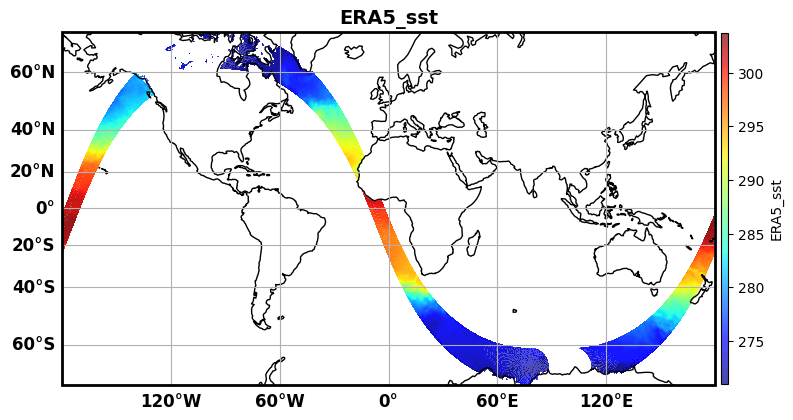

In [10]:
import os
import glob
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap

# Define channel names for GMI group subgroups
channel_names_S1 = ['10v', '10h', '18v', '18h', '23v', '36v', '36h', '89v', '89h']
channel_names_S2 = ['166v', '166h', '183-3', '183-7']

data_dir = r"/content/drive/Shared drives/SAFL Ebtehaj Group/Buddha Research/data_production/sample_netcdf_files"
#data_dir = r"G:\Shared drives\SAFL Ebtehaj Group\Buddha Research\data_production\sample_netcdf_files"

def visualise_BRAINS_prcprate(B_RAINS_PrcpRate, B_RAINS_Phase, longitude, latitude):
    mask = (longitude > 179.5) | (longitude < -179.5)

    # Define color maps
    colors_snow = ['grey', 'cyan', 'dodgerblue', 'blue', 'mediumvioletred']
    cmap_rate_snow = LinearSegmentedColormap.from_list("mycmap_snow", colors_snow)

    colors_rain = ['grey', 'yellow', 'red']
    cmap_rate_rain = LinearSegmentedColormap.from_list("mycmap_rain", colors_rain)

    # Compute rain and snow rates
    rain = np.where(B_RAINS_Phase == 1, B_RAINS_PrcpRate, 0)
    snow = np.where(B_RAINS_Phase == 2, B_RAINS_PrcpRate, 0)

    # Masking
    snow_masked = np.ma.masked_where(mask | (rain > snow), snow)
    rain_masked = np.ma.masked_where(mask | (snow > rain), rain)

    # Plotting
    fig, ax1 = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.Mercator()})

    plot1 = ax1.pcolormesh(longitude, latitude, snow_masked, vmin=0, vmax=1.2,
                           cmap=cmap_rate_snow, transform=ccrs.PlateCarree())
    plot2 = ax1.pcolormesh(longitude, latitude, rain_masked, vmin=0, vmax=4,
                           cmap=cmap_rate_rain, transform=ccrs.PlateCarree())

    # Coastlines and grid
    ax1.coastlines(alpha=0.3)
    g4 = ax1.gridlines(draw_labels=True, alpha=0.6)
    g4.top_labels = False
    g4.right_labels = False
    g4.xlabels_bottom = True
    g4.ylabels_left = True
    g4.xlabel_style = {'fontsize': 12, 'fontweight': 'bold'}
    g4.ylabel_style = {'fontsize': 12, 'fontweight': 'bold'}
    ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())

    for spine in ax1.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')

    ax1.set_title('B-RAINS Snow and Rain Rates [mm/hr]', fontsize=16, fontweight='bold')

    # Colorbars
    cbar_ax1 = fig.add_axes([0.91, 0.53, 0.01, 0.27])
    cbar_ax2 = fig.add_axes([0.91, 0.18, 0.01, 0.27])

    cbar1 = fig.colorbar(plot1, cax=cbar_ax1)
    cbar1.set_label('Snow rate', fontsize=11, fontweight='bold')

    cbar2 = fig.colorbar(plot2, cax=cbar_ax2)
    cbar2.set_label('Rain rate', fontsize=11, fontweight='bold')

    plt.show()


def visualize_brains_phase(lat, lon, data):
    # Custom colormap for B-RAINS_Phase (0=clear,1=rain,2=snow)
    cmap_custom = mcolors.ListedColormap(['grey', 'red', 'blue'])
    bounds = [0, 1, 2, 3]
    norm = mcolors.BoundaryNorm(bounds, cmap_custom.N)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection=ccrs.Mercator())

    # Mask out invalid longitudes
    mask = (lon > 179.5) | (lon < -179.5)
    data_masked = np.ma.masked_where(mask, data)

    pcm = ax.pcolormesh(lon, lat, data_masked, cmap=cmap_custom, norm=norm, alpha=0.98, transform=ccrs.PlateCarree())
    ax.coastlines(alpha=0.3)

    g4 = ax.gridlines(draw_labels=True, alpha=0.8)
    g4.top_labels = False
    g4.right_labels = False
    g4.xlabels_bottom = True
    g4.ylabels_left = True
    g4.xlabel_style = {'fontsize': 12, 'fontweight': 'bold'}
    g4.ylabel_style = {'fontsize': 12, 'fontweight': 'bold'}

    cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.75, pad=0.01, aspect=50)
    cbar.set_ticks([0.5, 1.5, 2.5])
    cbar.set_ticklabels(['Clear', 'Rain', 'Snow'])
    for t in cbar.ax.get_yticklabels():
        t.set_fontweight('bold')
        t.set_fontsize(11)
        t.set_rotation(90)
        t.set_ha('center')
        t.set_va('center')


    cbar.ax.tick_params(pad=10)
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')

    ax.set_title('B-RAINS_Phase', fontsize=14, fontweight='bold')
    plt.show()

def visualize_generic(lat, lon, data, var_name):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection=ccrs.Mercator())

    # Mask out invalid longitudes
    mask = (lon > 179.5) | (lon < -179.5)
    data_masked = np.ma.masked_where(mask, data)

    vmin = np.nanmin(data_masked)
    vmax = np.nanmax(data_masked)

    pcm = ax.pcolormesh(lon, lat, data_masked, cmap='jet', vmin=vmin, vmax=vmax, alpha=0.7, transform=ccrs.PlateCarree())
    ax.coastlines()

    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 12, 'fontweight': 'bold'}
    gl.ylabel_style = {'fontsize': 12, 'fontweight': 'bold'}

    for spine in ax.spines.values():
      spine.set_linewidth(2)
      spine.set_color('black')

    cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.76, pad=0.008, aspect=50)
    cbar.set_label(var_name)

    ax.set_title(var_name, fontsize=14, fontweight='bold')
    plt.show()

def main():
    orbit = input("Enter orbit number: ").strip()
    pattern = os.path.join(data_dir, f"B-RAINS_*_{orbit}.nc")
    files = glob.glob(pattern)

    if not files:
        print(f"No files found for orbit {orbit}. Please check and try again.")
        return

    file_path = files[0]
    print(f"Found file: {file_path}")

    nc = Dataset(file_path, "r")
    groups = list(nc.groups.keys())
    print("\nAvailable top-level groups:")
    for g in groups:
        print(f"  - {g}")

    group_choice = input("\nWhich group are you interested in? ").strip()

    if group_choice not in groups:
        print(f"Group '{group_choice}' not found.")
        return

    group = nc.groups[group_choice]

    # Special case: GMI has subgroups S1 and S2
    if group_choice == "GMI":
        subgroups = list(group.groups.keys())
        print("\nGMI subgroups:")
        for sg in subgroups:
            print(f"  - {sg}")

        subgroup_choice = input("\nWhich GMI subgroup do you want (S1 or S2)? ").strip()
        if subgroup_choice not in subgroups:
            print(f"Subgroup '{subgroup_choice}' not found.")
            return

        subgroup = group.groups[subgroup_choice]

        # Always read lat/lon from GMI S1 regardless of subgroup choice, if possible
        try:
            lat = group.groups["S1"].variables["LatS1"][:]
            lon = group.groups["S1"].variables["LonS1"][:]
        except Exception as e:
            print(f"Could not read LatS1/LonS1: {e}")
            return

        variables = list(subgroup.variables.keys())
        print(f"\nVariables in GMI/{subgroup_choice}:")
        for v in variables:
            print(f"  - {v}")

        var_choice = input("\nWhich variable do you want to visualize? ").strip()
        if var_choice not in variables:
            print(f"Variable '{var_choice}' not found in GMI/{subgroup_choice}.")
            return

        # Handle TbS1 or TbS2 (9 or 11 channels on 3rd dim)
        if var_choice in ["TbS1", "TbS2"]:
            # Determine channel names by subgroup
            if subgroup_choice == "S1":
                channels = channel_names_S1
            else:
                channels = channel_names_S2

            print(f"\nThis variable has {len(channels)} channels (3rd dimension indices 0 to {len(channels)-1}):")
            for i, ch_name in enumerate(channels):
                print(f"  {i}: {ch_name}")

            while True:
                idx_input = input(f"Enter the 3rd dimension index to visualize (0-{len(channels)-1}): ").strip()
                if idx_input.isdigit():
                    idx = int(idx_input)
                    if 0 <= idx < len(channels):
                        break
                print("Invalid input, please enter a valid index.")

            data_var = subgroup.variables[var_choice][:]  # read full variable

            selected_data = data_var[:, :, idx]

            var_title = f"{var_choice} - {channels[idx]}"
            visualize_generic(lat, lon, selected_data, var_title)
            return

        else:
            # Other variables in GMI subgroup
            data_var = subgroup.variables[var_choice][:]
            try:
                lat = group.groups["S1"].variables["LatS1"][:]
                lon = group.groups["S1"].variables["LonS1"][:]
            except Exception:
                print("Could not read lat/lon from GMI S1 subgroup for visualization.")
                return

            visualize_generic(lat, lon, data_var, var_choice)
            return

    # For other groups

    # If brains_group
    if group_choice == "B-RAINS":
        variables = list(group.variables.keys())
        print("\nVariables in B-RAINS group:")
        for v in variables:
            print(f"  - {v}")

        var_choice = input("\nWhich variable do you want to visualize? ").strip()
        if var_choice not in variables:
            print(f"Variable '{var_choice}' not found in B-RAINS.")
            return

        try:
            lat = nc.groups["GMI"].groups["S1"].variables["LatS1"][:]
            lon = nc.groups["GMI"].groups["S1"].variables["LonS1"][:]

        except Exception:
            print("Could not find lat/lon for plotting.")
            return

        data_var = group.variables[var_choice][:]

        if var_choice == "B-RAINS_Phase":
            ans = input("Do you want to visualize B-RAINS_Phase (yes/no)? ").strip().lower()
            if ans in ['yes', 'y']:
                visualize_brains_phase(lat, lon, data_var)
            else:
                print("Visualization skipped.")
            return
        else:
            ans = input(f"Do you want to visualize {var_choice} (yes/no)? ").strip().lower()
            if ans in ['yes', 'y']:
                B_RAINS_PrcpRate = data_var
                B_RAINS_Phase = group.variables["B-RAINS_Phase"][:]
                latitude = lat
                longitude = lon
                visualise_BRAINS_prcprate(B_RAINS_PrcpRate, B_RAINS_Phase, longitude, latitude)
            else:
                print("Visualization skipped.")
            return

    # For other groups (GPROF, GTOPO30, etc.)
    variables = list(group.variables.keys())
    if len(variables) == 0:
        print(f"No variables found in group '{group_choice}'.")
        return

    print(f"\nVariables in {group_choice}:")
    for v in variables:
        print(f"  - {v}")

    var_choice = input("\nWhich variable do you want to visualize? ").strip()
    if var_choice not in variables:
        print(f"Variable '{var_choice}' not found in {group_choice}.")
        return

    # Attempt lat/lon from GMI S1 for plotting if possible
    try:
        lat = nc.groups["GMI"].groups["S1"].variables["LatS1"][:]
        lon = nc.groups["GMI"].groups["S1"].variables["LonS1"][:]
    except Exception:
        print("Could not find lat/lon for plotting.")
        return

    data_var = group.variables[var_choice][:]

    ans = input(f"Do you want to visualize {var_choice} (yes/no)? ").strip().lower()
    if ans in ['yes', 'y']:
        visualize_generic(lat, lon, data_var, var_choice)
    else:
        print("Visualization skipped.")

if __name__ == "__main__":
    main()